<a id='top'></a>

# Beyond .85 

### A random forests algorithm applied to Lending Club data predicted default rates with .85 accuracy out of the box. 

#### Could streamlining the feature set from an initial 40, and randomly sampling grids of hyperparameter values, maintain or improve that accuracy?

#### This notebook contains all the steps for this project; skip to the code, questions and answers that interest you using the links below.

This project was to predict loan default rates using a data set from Lending Club. It entailed winnowing down 140+ initial features and creating a machine learning model that accomplished the goal with as few features as possible, followed by hyperparameter tuning via randomized search


- [Step 1](#Step_1) Make a data dictionary in Excel for review and notation
- [Step 2](#Step_2) Missing data visualizations and initial data review
- [Step 3](#Step_3) Outliers
- [Step 4](#Step_4) Preprocessing
- [Step 5](#Step_5) Consider characteristics of the data to choose an initial algorithm and strategy: Random forests with feature importance ranking to reduce the number of features
- [Finding I](#Finding_I) Going from 40 features to 5 features, accuracy was only reduced by .003, ending up at .851.
- [Finding II](#Finding_II) Using the iterative process to winnow features from 40 down to five arrived at five final features that were in the top five less than half the time for each of the previous iterations. 
- [Step 6](#Step_6) With a baseline random forests algorithm with five features producing .851, verify predictive strength with cross validation and look at results using another algorithm.
- [Finding III](#Finding_III) Using the final five features derived from the winnowing process, both random forests cross validation and naive Bayes resulted in the same .85 accuracy, demonstrating that .85 is robust, and not improved upon by another easy-to-slot-in algorithm.
- [Finding IV](#Finding_IV) Naive Bayes on the initial 40 features produced accuracy of .76.
- [Step 7](#Step_7) Investigate whether base predictive capacity can be improved by applying randomly sampled hyperparameter values, using a random hyperparameter grid and randomized search cross validation, based on a method described here:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- [Finding V](#Finding_V) Best parameter values from five samples, as well as means/modes for these values, are shown. Some were the same across samples.
- [Step 8](#Step_8) Do any of the sets of hyperparameters generated from the random grid searches on different samples improve predictive power?
- [Finding VI](#Finding_VI) Hyperparameter values derived from the random search grids on 2% and 5% samples (same values, oops) resulted in the highest test set prediction, .854, which is a very small increase from the default hyperparameter settings.
- [Step 9](#Step_9) Conduct a hyperparameter grid search using a grid comprised of values centered around values with the greatest effect in the previous steps. Use those parameters to see if accuracy improves.
- [Conclusion](#Conclusion) 
Seems the predictive capability with this algorithm and hyperparameter tuning is maxed out at .854. But it's a promising methodology for other algorithms that are more sensitive to hyperparameter tuning.


In [3]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<a id='Step_1'></a>

#### Step 1: Make a data dictionary in Excel for review and notations 
I used the Excel file to review and annotate, identifying which features were relevant, and which were redundant or not useful for other reasons.

In [2]:
df = pd.read_csv('C:/Users/rmbrm/Downloads/LoanStats_2015_v2/LoanStats_2015.csv', skiprows=1, low_memory=False) 
data_dictionary = pd.read_excel('C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/LCDataDictionary.xlsx') 
print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name',
                                                 'Description': 'description'})
df_dtypes = pd.DataFrame(df.dtypes,columns=['dtypes'])
df_dtypes = df_dtypes.reset_index()
df_dtypes['name'] = df_dtypes['index']
df_dtypes = df_dtypes[['name','dtypes']]

df_dtypes['first value'] = df.loc[0].values
preview = df_dtypes.merge(data_dictionary, on='name',how='left')

preview.to_excel('C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/variables2.xlsx')

153
['LoanStatNew', 'Description']


In [3]:
preview.head()

,name,dtypes,first value,description
0,id,object,NaN,A unique LC assigned ID for the loan listing.
1,member_id,float64,NaN,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,12000,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,funded_amnt,float64,12000,The total amount committed to that loan at that point in time.
4,funded_amnt_inv,float64,12000,The total amount committed by investors for that loan at that point in time.


Back to [top](#top) 

<a id='Step_2'></a>

#### Step 2: Missing data visualizations and initial data review 
- Missing data visualization tool showed data for many features were almost entirely missing, and 
- showed feature sets with matching missing data.
- I removed all features for which more than 50% of the data was missing.
- I removed features that contained the same information as other features
- I removed two empty rows at the end of the dataframe

In [4]:
loans_orig = df
loans_orig.shape

(421097, 145)

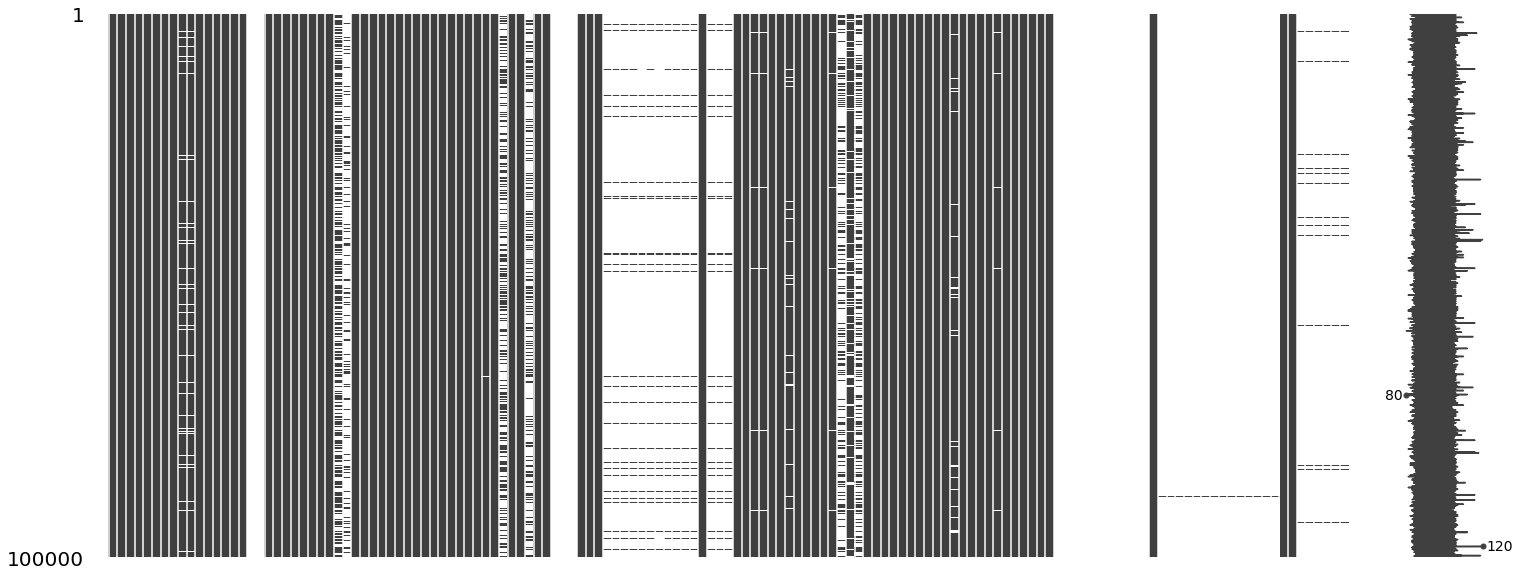

In [5]:
# 100,000
import missingno as msno
%matplotlib inline
msno.matrix(loans_orig.sample(100000))

Missing data visualization tool shows individual variables as columns, white is where data is missing. Shown are a low and high sampling rate. Variable names are not shown when there are more than 100.

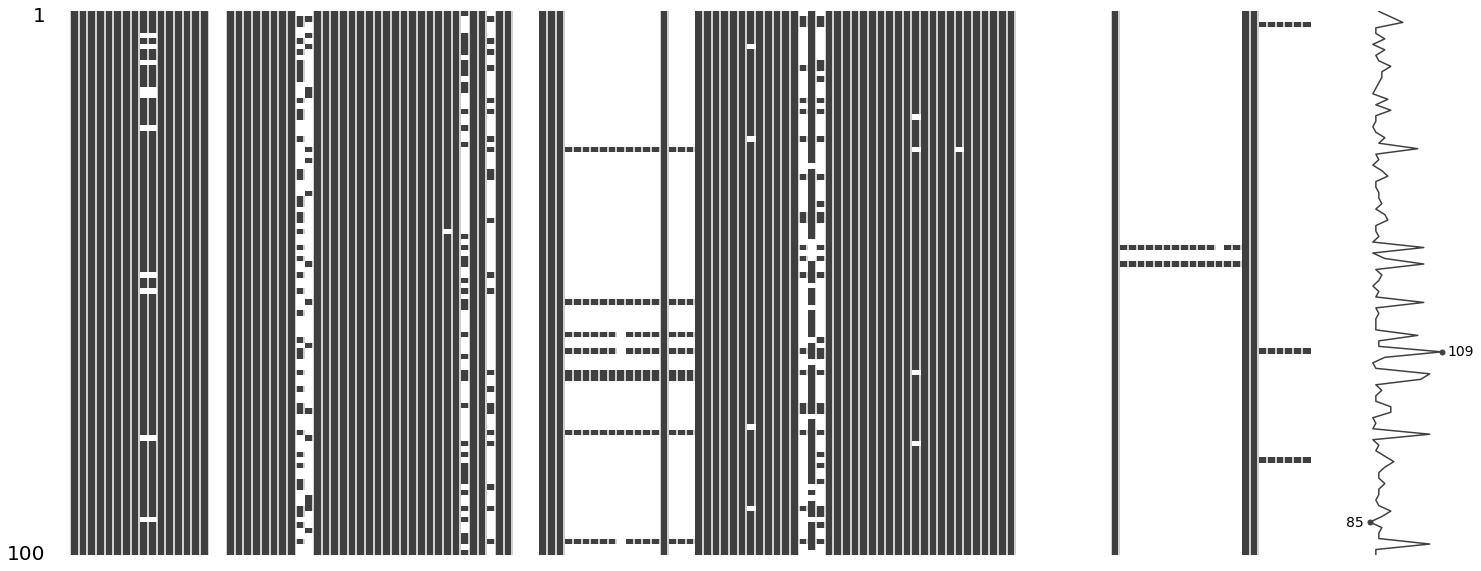

In [6]:
# 100
import missingno as msno
%matplotlib inline
msno.matrix(loans_orig.sample(100))

In [7]:
half_count = len(loans_orig) / 2
loans_abrdg = loans_orig.dropna(thresh=half_count,axis=1)
loans_abrdg.shape

(421097, 88)

In [8]:
missing = loans_orig.isnull().sum()
missing.sort_values(ascending=False)

sec_app_earliest_cr_line                      421097
revol_bal_joint                               421097
member_id                                     421097
url                                           421097
sec_app_inq_last_6mths                        421097
sec_app_mort_acc                              421097
sec_app_open_acc                              421097
sec_app_revol_util                            421097
sec_app_open_act_il                           421097
sec_app_num_rev_accts                         421097
sec_app_chargeoff_within_12_mths              421097
sec_app_collections_12_mths_ex_med            421097
sec_app_mths_since_last_major_derog           421097
id                                            421095
desc                                          421052
dti_joint                                     420588
annual_inc_joint                              420586
verification_status_joint                     420586
orig_projected_additional_accrued_interest    

In [9]:
# Remove empty rows at the end 
df = loans_abrdg
dfa = df.drop(df.index[421095])
dfb = dfa.drop(dfa.index[421095])
df = dfb


In [10]:
# ID features that have the same information
df['loan'] = np.where((df['loan_amnt'] == df['funded_amnt']) & (df['loan_amnt'] == df['funded_amnt_inv']), df['loan_amnt'], np.nan)

Back to [top](#top) 

<a id='Step_3'></a>

#### Step 3: Outliers
I first used the visualization library Plotly because it creates interactive boxplots, showing data values on hover, and allowing for zooming, panning, etc. Unfortunately, the data set was so big that only a few boxplots could be created in a single notebook. Therefore I recreated the boxplot using Seaborn. 

*Takeaway: None of the outliers are problematic; the boxplots show many features with high-skewing distributions, which is not surprising, considering the variables.*

In [11]:
# Create and format variables for box plots
time_vars = loans_orig[['mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl']].copy()
time_fin = time_vars.rename(index=str, columns={'mo_sin_old_rev_tl_op': 'Oldest Revolving Account Opened',
                                                'mo_sin_rcnt_rev_tl_op': 'Most Recent Revolving Account Opened',
                                                'mo_sin_rcnt_tl': 'Most Recent Account Opened'})
acct_vars = loans_orig[['num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats',
                        'num_tl_90g_dpd_24m', 'num_sats']].copy()
acct_fin = acct_vars.rename(index=str, columns={'num_accts_ever_120_pd': 'Accounts Ever 120 or More Days Past Due',
                                                'num_actv_bc_tl': 'Currently Active Bankcard Accounts',
                                                'num_actv_rev_tl': 'Currently Active Revolving Trades',
                                                'num_bc_sats': 'Satisfactory Bankcard Accounts',
                                                'num_tl_90g_dpd_24m': 'Accounts 90+ Days Past Due in Past 24 Months',
                                                'num_sats': 'Satisfactory Accounts'})


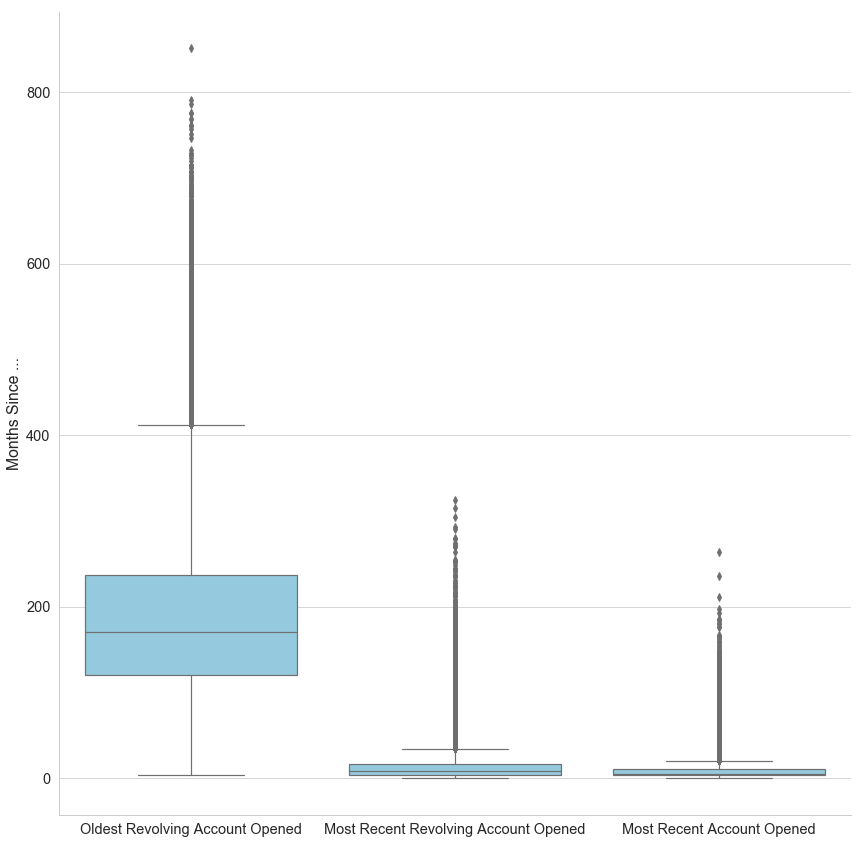

In [12]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.65) 
sns.catplot(kind='box',data=time_fin, height=12, color="skyblue")
plt.ylabel("Months Since ...")
plt.show()

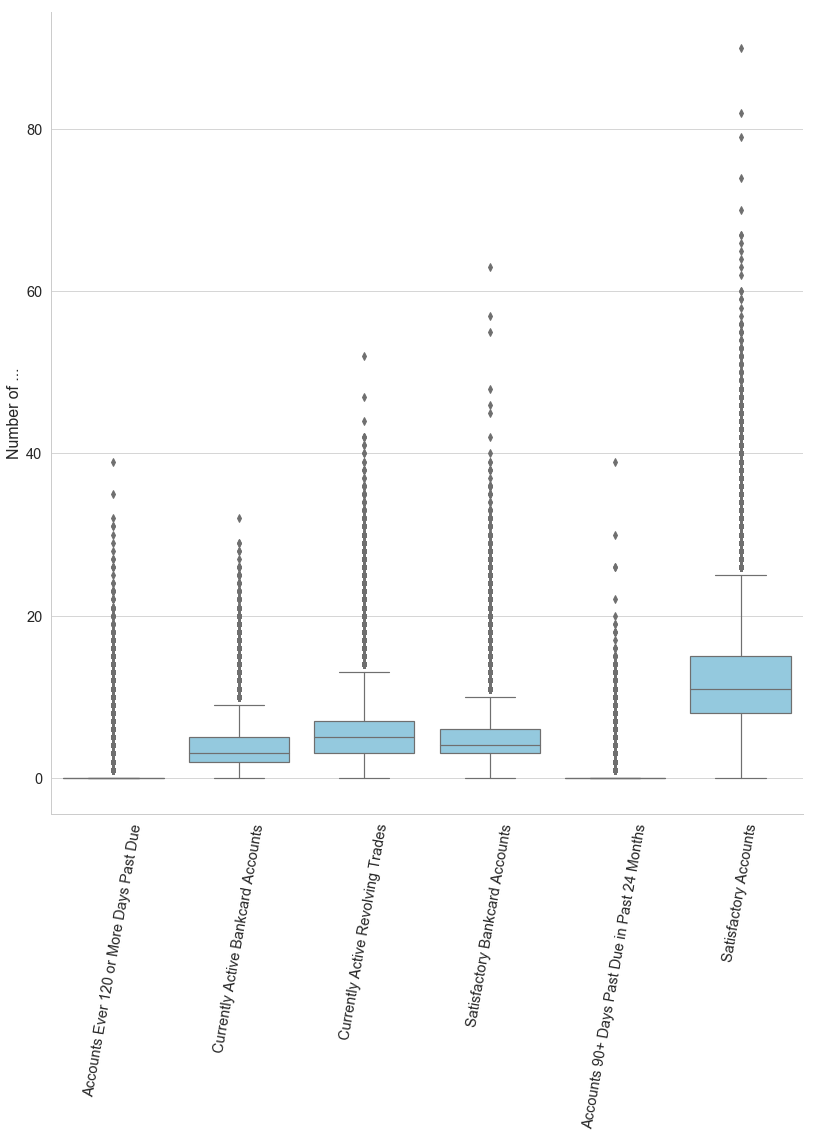

In [13]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.65) 
sns.catplot(kind='box',data=acct_fin, height=12, color="skyblue")
plt.ylabel("Number of ...")
plt.xticks(rotation='80')
plt.show()

Back to [top](#top) 

<a id='Step_4'></a>

#### Step 4: Preprocessing
- strip out text to create numeric features
- recode text variables to create numeric features and target
- remove irrelevant features
- where some features have very few cases of a particular value, drop those cases
- remove "future leakage" features that were identified during review of data dictionary, features such as "debt_settlement_flag"

In [14]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,loan
0,12000.0,12000.0,12000.0,60 months,9.80%,253.79,B,B3,Teacher,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,Debt consolidation,660xx,KS,23.84,0.0,Nov-2003,0.0,NaN,18.0,0.0,9786.0,13.4%,37.0,w,0.00,0.00,13842.626405,13842.63,12000.00,1842.63,0.0,0.0,0.0,Nov-2017,8529.37,Nov-2017,0.0,1.0,Individual,0.0,0.0,181540.0,73200.0,8.0,10086.0,41055.0,17.1,0.0,0.0,127.0,145.0,4.0,1.0,2.0,4.0,14.0,0.0,2.0,4.0,5.0,10.0,13.0,11.0,22.0,4.0,18.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,291626.0,74787.0,49500.0,105910.0,N,Cash,N,12000.0
1,25000.0,25000.0,25000.0,36 months,5.32%,752.87,A,A1,Director,1 year,MORTGAGE,150000.0,Not Verified,Dec-2015,Current,n,credit_card,Credit card refinancing,054xx,VT,9.54,0.0,Feb-1996,0.0,NaN,7.0,0.0,19339.0,42.5%,18.0,w,6628.03,6628.03,20257.290000,20257.29,18371.97,1885.32,0.0,0.0,0.0,Mar-2018,752.87,Aug-2017,0.0,1.0,Individual,0.0,0.0,430856.0,45500.0,1.0,61551.0,24661.0,44.0,0.0,0.0,166.0,238.0,4.0,4.0,7.0,73.0,NaN,0.0,1.0,1.0,3.0,3.0,4.0,4.0,7.0,1.0,7.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,512381.0,44786.0,44000.0,51081.0,N,Cash,N,25000.0
2,28000.0,28000.0,28000.0,60 months,18.49%,718.51,D,D5,Engineer,10+ years,MORTGAGE,75000.0,Verified,Dec-2015,Current,n,debt_consolidation,Debt consolidation,471xx,IN,31.88,0.0,Oct-2002,0.0,NaN,27.0,0.0,43413.0,51.9%,46.0,w,18904.38,18904.38,18609.350000,18609.35,9095.62,9513.73,0.0,0.0,0.0,Mar-2018,718.51,Mar-2018,0.0,1.0,Individual,0.0,0.0,193745.0,83600.0,8.0,7176.0,23476.0,59.9,0.0,0.0,143.0,158.0,4.0,4.0,2.0,10.0,16.0,0.0,14.0,20.0,14.0,18.0,9.0,24.0,34.0,20.0,27.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,267312.0,57302.0,58500.0,31758.0,N,Cash,N,28000.0
3,30000.0,30000.0,30000.0,36 months,15.77%,1051.31,D,D1,Vice-President,2 years,MORTGAGE,175000.0,Not Verified,Dec-2015,Fully Paid,n,home_improvement,Home improvement,430xx,OH,18.50,0.0,Aug-1997,1.0,61.0,9.0,0.0,21831.0,50.3%,23.0,w,0.00,0.00,33903.765739,33903.77,30000.00,3903.77,0.0,0.0,0.0,Dec-2016,23456.38,Sep-2017,0.0,1.0,Individual,0.0,0.0,408118.0,43400.0,7.0,51015.0,21569.0,50.3,0.0,0.0,118.0,220.0,16.0,6.0,3.0,16.0,0.0,0.0,2.0,2.0,3.0,7.0,9.0,4.0,11.0,2.0,9.0,0.0,0.0,0.0,3.0,95.7,33.3,0.0,0.0,447599.0,152571.0,43400.0,146568.0,N,Cash,N,30000.0
4,17600.0,17600.0,17600.0,60 months,19.89%,465.22,E,E3,RN,< 1 year,RENT,44000.0,Verified,Dec-2015,Current,n,credit_card,NaN,322xx,FL,17.56,0.0,Jun-2006,0.0,NaN,7.0,0.0,12900.0,102.4%,25.0,w,12017.72,12017.72,12047.100000,12047.10,5582.28,6464.82,0.0,0.0,0.0,Mar-2018,465.22,Mar-2018,0.0,1.0,Individual,0.0,0.0,133285.0,12600.0,1.0,19041.0,0.0,102.4,0.0,0.0,112.0,114.0,25.0,13.0,0.0,25.0,NaN,0.0,3.0,3.0,3.0,3.0,21.0,3.0,4.0,3.0,7.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,139633.0,133285.0,12600.0,127033.0

In [15]:
cols1 = ['term']
df[cols1] = df[cols1].replace({' months': ''}, regex=True)
cols2 = ['int_rate', 'revol_util']
df[cols2] = df[cols2].replace({'%': ''}, regex=True)
df[cols2] = df[cols2].replace({' ': ''}, regex=True)

In [16]:
df["revol_util"] = df.revol_util.astype(float)
df["int_rate"] = df.int_rate.astype(float)
df["term"] = df.term.astype(float)

In [17]:
df.hardship_flag = df.hardship_flag.replace({"N": 0, "Y": 1})
df.grade = df.grade.replace({"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1})
df.emp_length = df.emp_length.replace({"10+ years": 10, "1 year": 1, "< 1 year": .5, "2 years": 2, "3 years": 3,
                                       "4 years": 4, "5 years": 5, "6 years": 6, "7 years": 7, "8 years": 8, "9 years": 9})
df['default'] = df['loan_status']
recode = {'Fully Paid': 0, 'Current': 0, 'Charged Off': 1, 'Late (31-120 days)': 0,'In Grace Period': 0,
          'Late (16-30 days)': 0, 'Default': 1}
df['default'] = df['default'].apply(lambda x: recode[x])
drop_cols = ['funded_amnt', 'addr_state', 'debt_settlement_flag', 'loan_amnt', 'funded_amnt_inv', 'sub_grade', 'emp_title',
             'issue_d', 'loan_status', 'pymnt_plan', 'last_pymnt_d', 'title', 'zip_code', 'earliest_cr_line', 'revol_bal',
             'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
             'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
             'last_pymnt_amnt', 'last_credit_pull_d', 'policy_code', 'application_type', 'tot_coll_amt', 'tot_cur_bal',
             'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'delinq_amnt', 'mort_acc', 'num_actv_rev_tl',
             'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'tot_hi_cred_lim',
             'total_bal_ex_mort', 'disbursement_method', 'mths_since_last_delinq', 'mths_since_recent_inq', 'num_tl_120dpd_2m']
data_filtered = df.drop(drop_cols, axis=1)
data_filtered.shape 

(421095, 41)

In [18]:
data_filtered = df.drop(drop_cols, axis=1)
data_filtered.shape 

(421095, 41)

In [19]:
data_filtered.to_pickle ("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_41_variables", compression='infer', protocol=4)
df = data_filtered

Check for low count values on various features; delete cases with the low count values

In [20]:
df['home_ownership'].value_counts()

MORTGAGE    207683
RENT        167644
OWN          45766
ANY              2
Name: home_ownership, dtype: int64

In [21]:
df['verification_status'].value_counts()

Source Verified    179565
Verified           123016
Not Verified       118514
Name: verification_status, dtype: int64

In [22]:
df['purpose'].value_counts()

debt_consolidation    250020
credit_card           102025
home_improvement       25293
other                  19204
major_purchase          7449
medical                 3938
car                     3466
small_business          3364
moving                  2420
vacation                2249
house                   1438
renewable_energy         224
wedding                    4
educational                1
Name: purpose, dtype: int64

In [23]:
df.verification_status = df.verification_status.replace({"Source Verified": 1, "Verified": 2, "Not Verified": 3})
df.purpose = df.purpose.replace({"debt_consolidation": 1, "credit_card": 2, "home_improvement": 3, "other": 4,
                                 "major_purchase": 5, "medical": 6, "car": 7, "small_business": 8, "moving": 9,
                                 "vacation": 10, "house": 11})
df.home_ownership = df.home_ownership.replace({"MORTGAGE": 1, "RENT": 2, "OWN": 3})

In [24]:
df = df[df.purpose != 'wedding']
df = df[df.purpose != 'educational']
df = df[df.purpose != 'renewable_energy']
df = df[df.home_ownership != 'ANY']

In [25]:
df.to_pickle ("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_processed", compression='infer', protocol=4)

Back to [top](#top) 

<a id='Step_5'></a>

#### Step 5: Consider characteristics of the data and the goal of the project to formulate and implement a machine learning plan
- There are many features, so an algorithm that does not require scaling or one-hot encoding is a good starting point 
- Ergo, run a random forests
- Iteratively investigate feature importance to see if features can be removed without having a great effect on prediction accuracy
- With a predictive model finalized, run the analysis with cross validation rather than just train/test split to ensure model generalizability



In [26]:
df = df.dropna()

In [27]:
df.shape

(353257, 41)

In [28]:
features = df.drop(df.columns[40], axis=1).values 
target = df['default'].values
#QC 
type (features), type(target)

(numpy.ndarray, numpy.ndarray)

In [29]:
#QC 
print(features)

[[60.0 9.8 253.79 ... 105910.0 0 12000.0]
 [36.0 5.32 752.87 ... 51081.0 0 25000.0]
 [60.0 18.49 718.51 ... 31758.0 0 28000.0]
 ...
 [60.0 19.99 317.86 ... 69919.0 0 12000.0]
 [60.0 15.99 316.07 ... 33239.0 0 13000.0]
 [36.0 11.99 664.2 ... 0.0 0 20000.0]]


In [30]:
#QC 
print(target)

[0 0 0 ... 1 1 0]


##### Note
QC steps shown above were run throughout this project, but have been omitted for brevity.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.854


Feature ranking:
1. feature 1 (0.055382)
2. feature 9 (0.053760)
3. feature 21 (0.050187)
4. feature 20 (0.048370)
5. feature 14 (0.048241)
6. feature 36 (0.048076)
7. feature 17 (0.047976)
8. feature 37 (0.046817)
9. feature 2 (0.046501)
10. feature 18 (0.046459)
11. feature 6 (0.045371)
12. feature 24 (0.037675)
13. feature 39 (0.037403)
14. feature 22 (0.031806)
15. feature 28 (0.029101)
16. feature 12 (0.028824)
17. feature 23 (0.028712)
18. feature 32 (0.028229)
19. feature 3 (0.024467)
20. feature 4 (0.024177)
21. feature 27 (0.023469)
22. feature 33 (0.023395)
23. feature 26 (0.022620)
24. feature 31 (0.020769)
25. feature 8 (0.014574)
26. feature 11 (0.013245)
27. feature 25 (0.011907)
28. feature 7 (0.011105)
29. feature 5 (0.009928)
30. feature 10 (0.009706)
31. feature 13 (0.007465)
32. feature 0 (0.005742)
33. feature 34 (0.005590)
34. feature 30 (0.004212)
35. feature 35 (0.003629)
36. feature 15 (0.002547)
37. feature 19 (0.001340)
38. feature 16 (0.000687)
39. feature 29

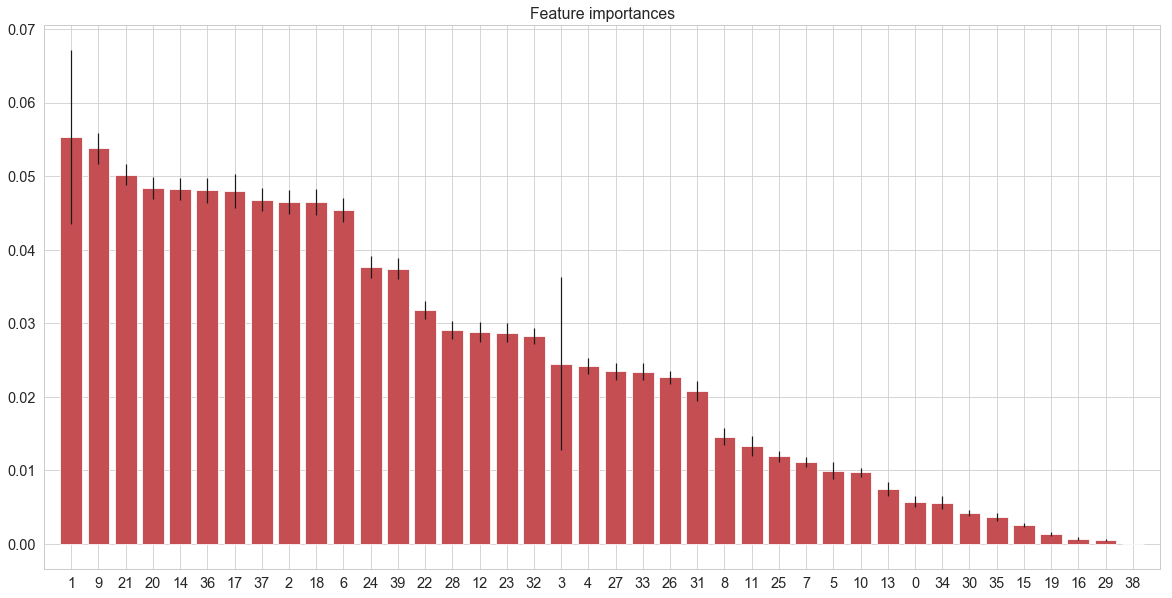

In [33]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [34]:
feature_list = df.dtypes
feature_list.to_excel('C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/feature_list.xlsx')
bottom_20 = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'delinq_2yrs', 'inq_last_6mths',
             'pub_rec', 'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths', 'num_accts_ever_120_pd',
             'num_actv_bc_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'percent_bc_gt_75',
             'pub_rec_bankruptcies', 'tax_liens', 'hardship_flag']
data_filtered = df.drop(bottom_20, axis=1)
df = data_filtered
df.shape

(353257, 21)

In [35]:
features = df.drop(df.columns[20], axis=1).values 
target = df['default'].values

(numpy.ndarray, numpy.ndarray)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.854


Feature ranking:
1. feature 0 (0.083710)
2. feature 4 (0.065978)
3. feature 10 (0.062160)
4. feature 7 (0.059878)
5. feature 17 (0.059820)
6. feature 9 (0.059803)
7. feature 6 (0.059434)
8. feature 18 (0.058063)
9. feature 1 (0.057769)
10. feature 8 (0.057742)
11. feature 3 (0.054832)
12. feature 19 (0.045082)
13. feature 13 (0.044284)
14. feature 11 (0.036339)
15. feature 16 (0.036230)
16. feature 5 (0.033735)
17. feature 15 (0.033382)
18. feature 12 (0.033040)
19. feature 14 (0.029811)
20. feature 2 (0.028908)


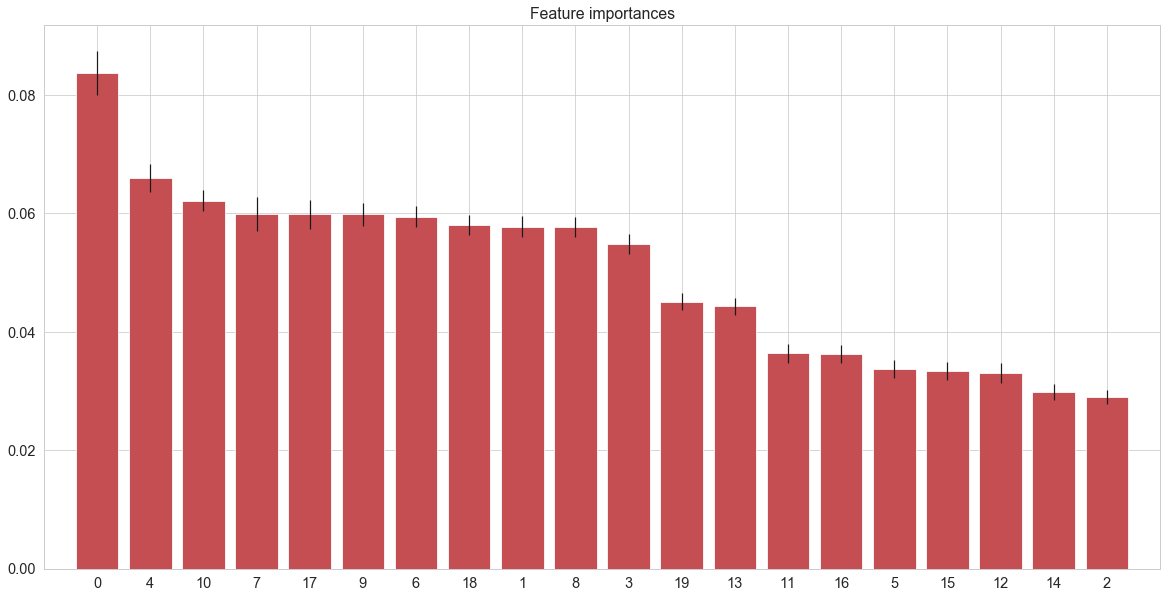

In [40]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [41]:
feature_list2 = df.dtypes
feature_list2.to_excel('C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/feature_list2.xlsx')
bottom_9 = ['emp_length', 'open_acc', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'num_bc_sats',
            'num_sats', 'pct_tl_nvr_dlq', 'loan']
data_filtered = df.drop(bottom_9, axis=1)
df = data_filtered
df.shape

(353257, 12)

In [42]:
features = df.drop(df.columns[11], axis=1).values 
target = df['default'].values

(numpy.ndarray, numpy.ndarray)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.854


Feature ranking:
1. feature 0 (0.100236)
2. feature 3 (0.099746)
3. feature 1 (0.092544)
4. feature 4 (0.091161)
5. feature 8 (0.091004)
6. feature 10 (0.091002)
7. feature 5 (0.090087)
8. feature 7 (0.088441)
9. feature 9 (0.088263)
10. feature 6 (0.086806)
11. feature 2 (0.080710)


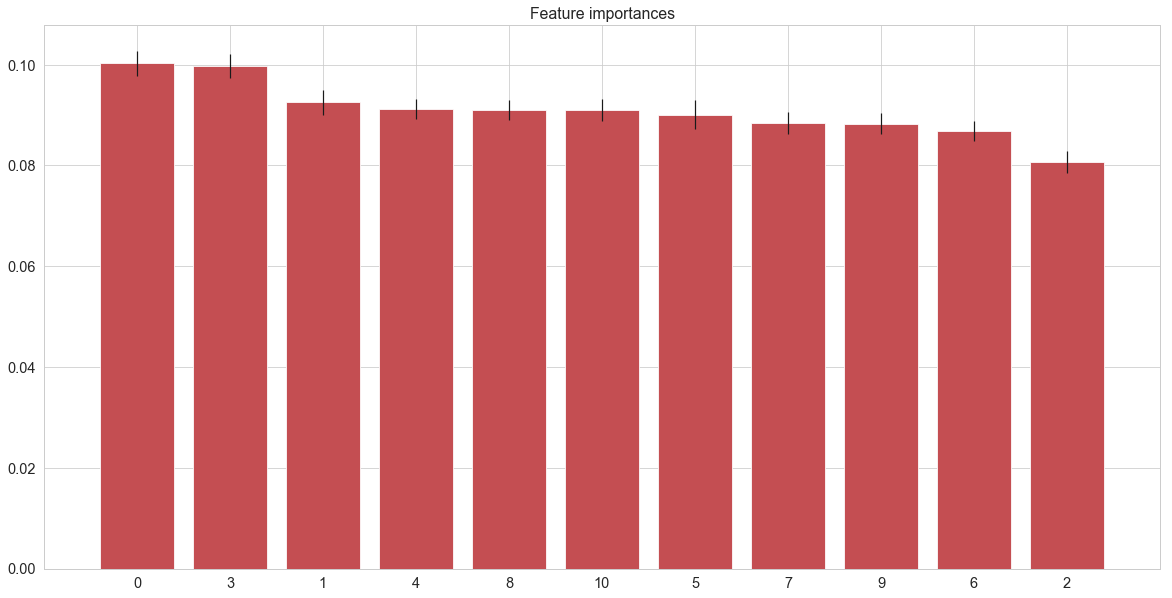

In [46]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [47]:
feature_list3 = df.dtypes
feature_list3.to_excel('C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/feature_list3.xlsx')
bottom_6 = ['annual_inc', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'total_bc_limit', 'total_il_high_credit_limit']
data_filtered = df.drop(bottom_6, axis=1)
df = data_filtered
df.shape

(353257, 6)

In [49]:
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values

(numpy.ndarray, numpy.ndarray)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score( X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.851


Feature ranking:
1. feature 2 (0.236933)
2. feature 3 (0.226616)
3. feature 1 (0.200177)
4. feature 4 (0.198367)
5. feature 0 (0.137906)


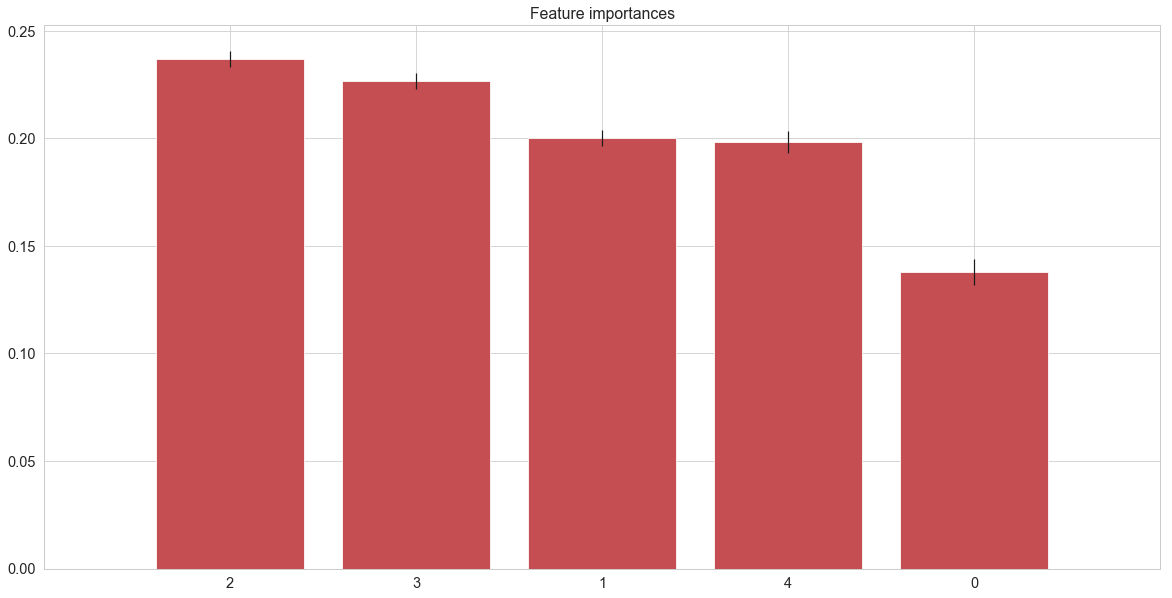

In [53]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Feature ranking:
1. feature 2 (0.236933)
2. feature 3 (0.226616)
3. feature 1 (0.200177)
4. feature 4 (0.198367)
5. feature 0 (0.137906)


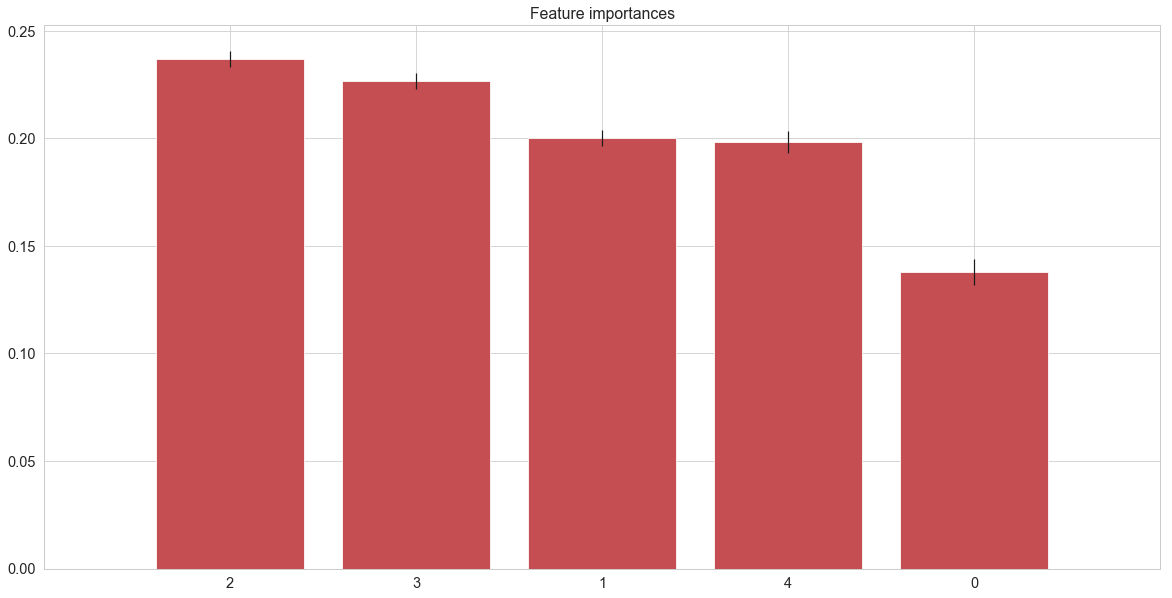

In [53]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

<a id='Finding_I'></a>

#### Finding I
Going from 40 features to 5 features, accuracy was only reduced by .003, ending up at .851.

<a id='Finding_II'></a>

#### Finding II
Using the iterative process to winnow features from 40 down to five arrived at five final features that were in the top five just more than half the time for each of the previous iterations. The rankings of the final five features in the first three iterations are as follows:

Final five rankings in the first iteration:
2, 3, 10, 15, 22

Final five rankings in the second iteration:
1, 2, 5, 7, 11

Final five rankings in the third iteration:
1, 2, 4, 5, 9

Back to [top](#top) 

<a id='Step_6'></a>

#### Step 6: How does this result stack up? Compare results to cross validation and another algorithm

- With a predictive model finalized, run the analysis with cross validation rather than just train/test split to ensure model generalizability
- Compare results to naive Bayes, both on final most effective features as determined from the random forest iterations, and naive Bayes on the initial 40 features.



In [4]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values

In [8]:
# cross val with three folds on final five features 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
scores = cross_val_score(forest, features, target)

print('Cross validation with three folds on final five features:')
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.3f}".format(scores.mean()))


Cross-validation scores: [0.85335405 0.85180719 0.84379883]
Average cross-validation score: 0.850


In [9]:
# cross val with five folds

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, random_state = 42)
scores = cross_val_score(forest, features, target, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.3f}".format(scores.mean()))


Cross-validation scores: [0.85341033 0.85337787 0.85237293 0.85108491 0.85095752]
Average cross-validation score: 0.852


In [10]:
# Bayes on five features

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score

#df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 


X_train, X_test, y_train, y_test = train_test_split(features, target)
clf = GaussianNB()
clf.fit(X_train, y_train)

print("Bayes on five features:")
print("Accuracy on training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))


Accuracy on training set: 0.849
Accuracy on test set: 0.850


In [12]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_41_cleaned") 
features = df.drop(df.columns[40], axis=1).values 
target = df['default'].values

(353257, 41)

In [16]:
# Bayes on 40 features

X_train, X_test, y_train, y_test = train_test_split(features, target)
clf = GaussianNB()
clf.fit(X_train, y_train)
print("Bayes on 40 features:")
print("Accuracy on training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))


Accuracy on training set: 0.785
Accuracy on test set: 0.785


<a id='Finding_III'></a>

#### Finding III
Using the final five features derived from the winnowing process, both random forests cross validation and naive Bayes resulted in the same .85 accuracy, demonstrating that .85 is robust, and not improved upon by another easy-to-slot-in algorithm.

<a id='Finding_IV'></a>

#### Finding IV
Naive Bayes on the initial 40 features produced accuracy of .79.

Back to [top](#top) 

<a id='Step_7'></a>

#### Step 7: Random grid search for hyperparameter tuning

- Investigate whether base predictive capacity can be improved by applying randomly sampled hyperparameter values, using a random hyperparameter grid and randomized search cross validation, based on a method described here: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- Running the analyses on all data was not practical (it took hours). Instead I sampled the data set and compared outcomes from various sample sizes. The code and results for a sample of .5% of the 353,257 cases are shown, followed by results from several additional samples.

In [55]:
# What are default hyperparameters
from pprint import pprint
pprint('Parameters currently in use:\n')
pprint(forest.get_params())

'Parameters currently in use:\n'
{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [56]:
# CREATE THE SEARCH GRID

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [2]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 
sample = df.sample(n=1766)
df = sample
df.shape

(1766, 6)

In [5]:
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [65]:
# ANALYSIS WITH HYPER PARAMETER GRID SEARCH: base model
forest = RandomForestClassifier()

# Random parameter search, three fold cross validation, 
forest_random =  RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
forest_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [66]:
# show the best performing parameters based on the .5% sample

forest_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

<a id='Finding_V'></a>

#### Finding V
Best parameters from five samples, as well as means/modes for these values, are shown below. Many were the same across samples.

In [5]:
df = pd.read_excel("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/parameters dataframe.xlsx",index_col=0)
df

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
Sample Size,,,,,,
0.005,1400,5,4,sqrt,80,True
0.01,400,10,4,sqrt,30,True
0.02,200,5,4,auto,10,True
0.05,200,5,4,auto,10,True
0.1,1400,5,4,sqrt,80,True
Mean/mode,720,6,4,sqrt,42,True


Back to [top](#top) 

<a id='Step_8'></a>

#### Step 8: Do any of the sets of hyperparameters generated from the random grid searches on different samples improve predictive power?

- I ran the sets of hyperparameters generated from Step 7 to see if any improved upon the best prediction score of .852 using default parameters.

In [6]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values

(353257, 6)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators=1400, min_samples_split=5, min_samples_leaf= 4, max_features= 'sqrt', 
                                max_depth=80, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print(".5%")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")

forest = RandomForestClassifier(n_estimators=400, min_samples_split=10, min_samples_leaf= 4, max_features= 'sqrt', 
                                max_depth=30, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print("1%")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")

forest = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf= 4, max_features= 'auto', 
                                max_depth=10, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print("2%")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")
forest = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf= 4, max_features= 'auto', 
                                max_depth=10, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print("5%")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")
forest = RandomForestClassifier(n_estimators=1400, min_samples_split=5, min_samples_leaf= 4, max_features= 'sqrt', 
                                max_depth=80, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print("10%")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")
forest = RandomForestClassifier(n_estimators=720, min_samples_split=6, min_samples_leaf= 4, max_features= 'sqrt', 
                                max_depth=42, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("--\n")
print("Mean/mode")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))
print("--")

--

.5%
Accuracy on training set: 0.888
Accuracy on test set: 0.853
--
--

1%
Accuracy on training set: 0.881
Accuracy on test set: 0.853
--
--

2%
Accuracy on training set: 0.856
Accuracy on test set: 0.854
--
--

5%
Accuracy on training set: 0.856
Accuracy on test set: 0.854
--
--

10%
Accuracy on training set: 0.888
Accuracy on test set: 0.853
--
--

Mean/mode
Accuracy on training set: 0.888
Accuracy on test set: 0.853
--


<a id='Finding_VI'></a>

#### Finding VI
The hyperparameter values derived from the random search grids on 2% and 5% samples (same values, oops) resulted in the highest test set prediction, .854, which is a very small increase from the default hyperparameter settings.

Back to [top](#top) 

<a id='Step_9'></a>

#### Step 9: Conduct a hyperparameter grid search using a grid comprised of values centered around values with the greatest effect in the previous steps. Use those parameters to see if accuracy improves.

- Based again on the article linked to above by Will Koehrsen, I implemented a hyperparameter grid search developed from the most effective values generated in the previous steps on a 10% sample. Then I applied the final hyperparameters to the full data set.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
n_estimators = [100, 200, 300]
max_features = ['auto']
max_depth = [10, 20, 30, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [2, 4, 6]
bootstrap = [True]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 
sample = df.sample(n=35326)
df = sample
df.shape

(35326, 6)

In [9]:
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values
X_train, X_test, y_train, y_test = train_test_split(features, target)

In [12]:
# ANALYSIS WITH HYPER PARAMETER GRID SEARCH: base model
forest = RandomForestClassifier()

# Random parameter search, three fold cross validation, 
forest_random =  RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
forest_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300], 'max_features': ['auto'], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 6], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [13]:
# best performing parameters

forest_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [14]:
df = pd.read_pickle("C:/Users/rmbrm/Documents/DS_WP/Predict default/Predict Default Final/data_for_hyper_tuning") 
df.shape

(353257, 6)

In [15]:
features = df.drop(df.columns[5], axis=1).values 
target = df['default'].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 42)
forest = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf= 6, max_features= 'auto', 
                                max_depth=10, bootstrap= True, random_state = 42)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))


Accuracy on training set: 0.856
Accuracy on test set: 0.854


<a id='Conclusion'></a>

#### Conclusion
Seems the predictive capability with this algorithm and hyperparameter tuning is maxed out at .854. But it's a promising methodology for other algorithms that are more sensitive to hyperparameter tuning.

Back to [top](#top) 